In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency

columns = ['class','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat']
df = pd.read_table('C:/Users/김미섭/OneDrive/바탕 화면/2021-1/ITS/스터디_실전반/breast-cancer.data',
                   sep=',', header=None, names=columns)

In [2]:
df

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


종속변수 class, 나머지 변수는 설명변수

Age: age of the patient at the time of diagnosis (진단 시 나이)   
Menopause: whether the patient is pre- or postmenopausal at time of diagnosis (진단 시 폐경기 전후)   
it40 : less than 40 (폐경x), ge40 : greater than or equal to 40 (폐경O), premenopause : 40이전이지만 폐경O
Tumor size: the greatest diameter (in mm) of the excised tumor (종양 크기)   
Inv-nodes: the number (range 0 - 39) of axillary lymph nodes that contain metastatic breast cancer visible on histological examination (전이성 유방암을 포함하는 겨드랑 림프절 수)   
Node caps: penetration of the tumor in the lymph node capsule or not (림프절 캡슐 내 종양 침투 여부)  
Degree of malignancy: the histological grade (range 1-3) of the tumor (종양의 조직학적 등급)  
  grade: 1 predominantly that consist of cancer cells (주로 암세포로 구성)  
  grade: 2 neoplastic that consist of usual characteristics of cancer cells (암세포의 일반적인 특성으로 구성된 신플라스틱)  
  grade: 3 predominately that consist of cells that are highly affected (주로 영향을 많이 받는 세포로 구성)  
Breast: breast cancer may obviously occur in either breast (방향)   
Breast quadrant: the breast may be divided into four quadrants, using the nipple as a central point (사분면)   
Irradiation: patient's radiation (x-rays) therapy history (방사선 치료 여부)  

In [3]:
ncol = df.shape[1]
nrow = df.shape[0]

### 변수 확인

In [4]:
df.isnull().sum()

class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


대부분의 변수가 categorical variable이다.

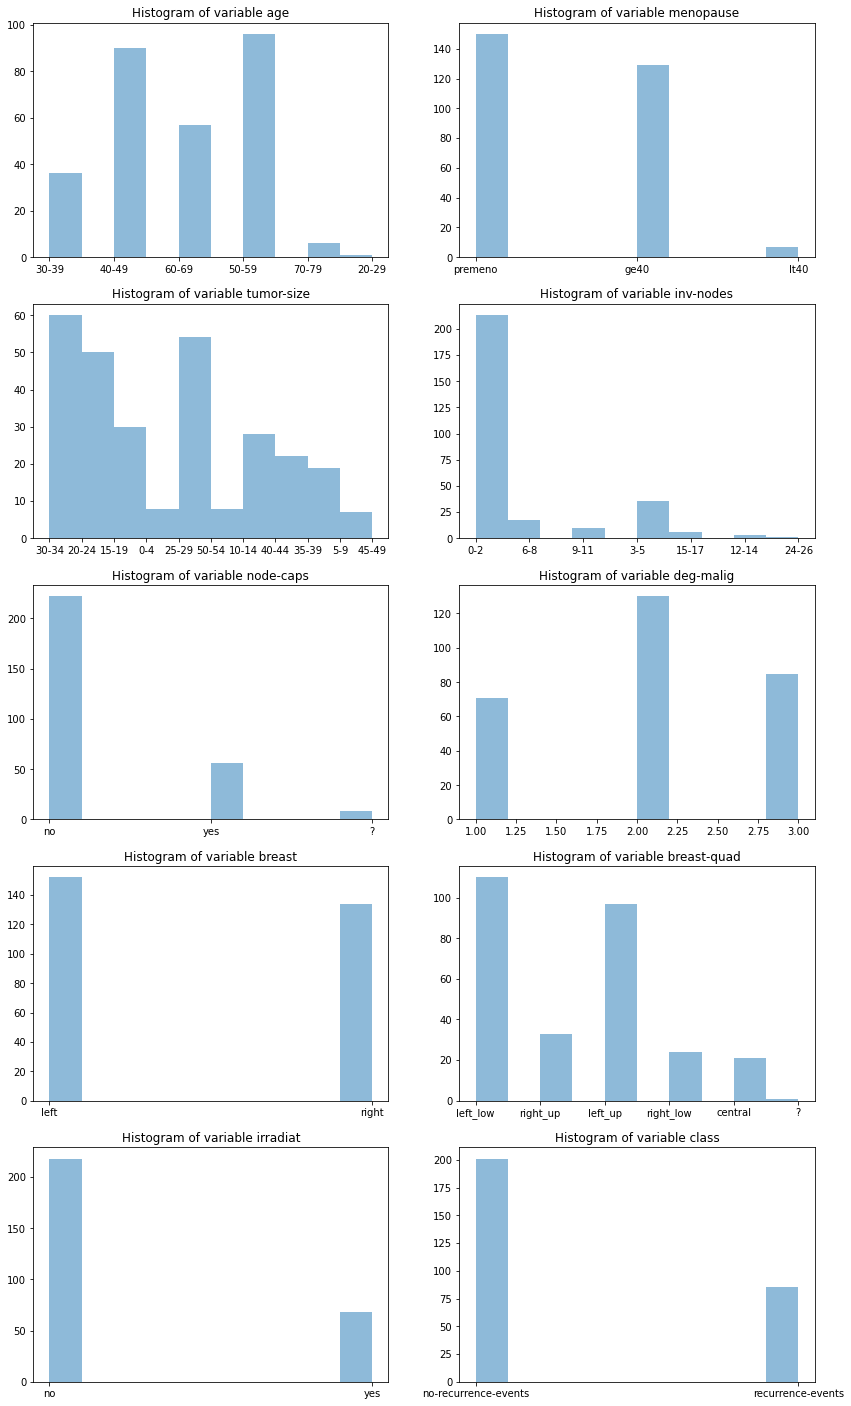

In [6]:
plt.rcParams["figure.figsize"] = (14,25)
for i in range(ncol):
    var = columns[i]
    place = ''.join(['52',str(i)])
    plt.subplot(place)
    plt.hist(df[var], alpha=0.5)
    plt.title(''.join(['Histogram of variable ',var]))
plt.show()

node-caps, breast-quad 변수에서 '?'값이 나타나 전처리가 필요하다.

In [7]:
df['node-caps'].unique()

array(['no', 'yes', '?'], dtype=object)

In [8]:
df[df['node-caps']=='?']

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
145,no-recurrence-events,40-49,premeno,25-29,0-2,?,2,left,right_low,yes
163,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_up,yes
164,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_low,yes
183,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_up,yes
184,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_low,yes
233,recurrence-events,70-79,ge40,15-19,9-11,?,1,left,left_low,yes
263,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_up,no
264,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_low,no


림프절 캡슐 내 종양 침투 여부를 알아내지 못한 것으로 파악되어 (missing value) 해당 관측치 삭제

In [9]:
df['breast-quad'].unique()

array(['left_low', 'right_up', 'left_up', 'right_low', 'central', '?'],
      dtype=object)

In [10]:
df[df['breast-quad']=='?']

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
206,recurrence-events,50-59,ge40,30-34,0-2,no,3,left,?,no


마찬가지로 사분면 파악을 못한 것으로 생각되어 (missing value) 해당 관측치 삭제

In [11]:
df1 = df.drop([145,163,164,183,184,233,263,264,206],axis=0)
df1 = df1.reset_index()
df1 = df1.drop('index', axis=1)
df1.shape

(277, 10)

### 순서형 변수는 평균값으로 대체

age, tumor-size, inv-nodes에 대해 순차적으로 대체

In [12]:
def to_mean(colname) :
    category = df1[colname].unique()
    for i in category:
        lower = int(i.split('-')[0])
        upper = int(i.split('-')[1])
        mean = (lower+upper)/2
        df1.loc[df1[colname]==i,colname]=mean
    print(colname, 'is changed to numeric variable')

In [13]:
to_mean('age')

age is changed to numeric variable


In [14]:
to_mean('tumor-size')

tumor-size is changed to numeric variable


In [15]:
to_mean('inv-nodes')

inv-nodes is changed to numeric variable


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        277 non-null    object
 1   age          277 non-null    object
 2   menopause    277 non-null    object
 3   tumor-size   277 non-null    object
 4   inv-nodes    277 non-null    object
 5   node-caps    277 non-null    object
 6   deg-malig    277 non-null    int64 
 7   breast       277 non-null    object
 8   breast-quad  277 non-null    object
 9   irradiat     277 non-null    object
dtypes: int64(1), object(9)
memory usage: 21.8+ KB


object type 변수를 float type으로

In [17]:
df1[['age','tumor-size','inv-nodes']]=df1[['age','tumor-size','inv-nodes']].apply(pd.to_numeric)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   class        277 non-null    object 
 1   age          277 non-null    float64
 2   menopause    277 non-null    object 
 3   tumor-size   277 non-null    float64
 4   inv-nodes    277 non-null    float64
 5   node-caps    277 non-null    object 
 6   deg-malig    277 non-null    int64  
 7   breast       277 non-null    object 
 8   breast-quad  277 non-null    object 
 9   irradiat     277 non-null    object 
dtypes: float64(3), int64(1), object(6)
memory usage: 21.8+ KB


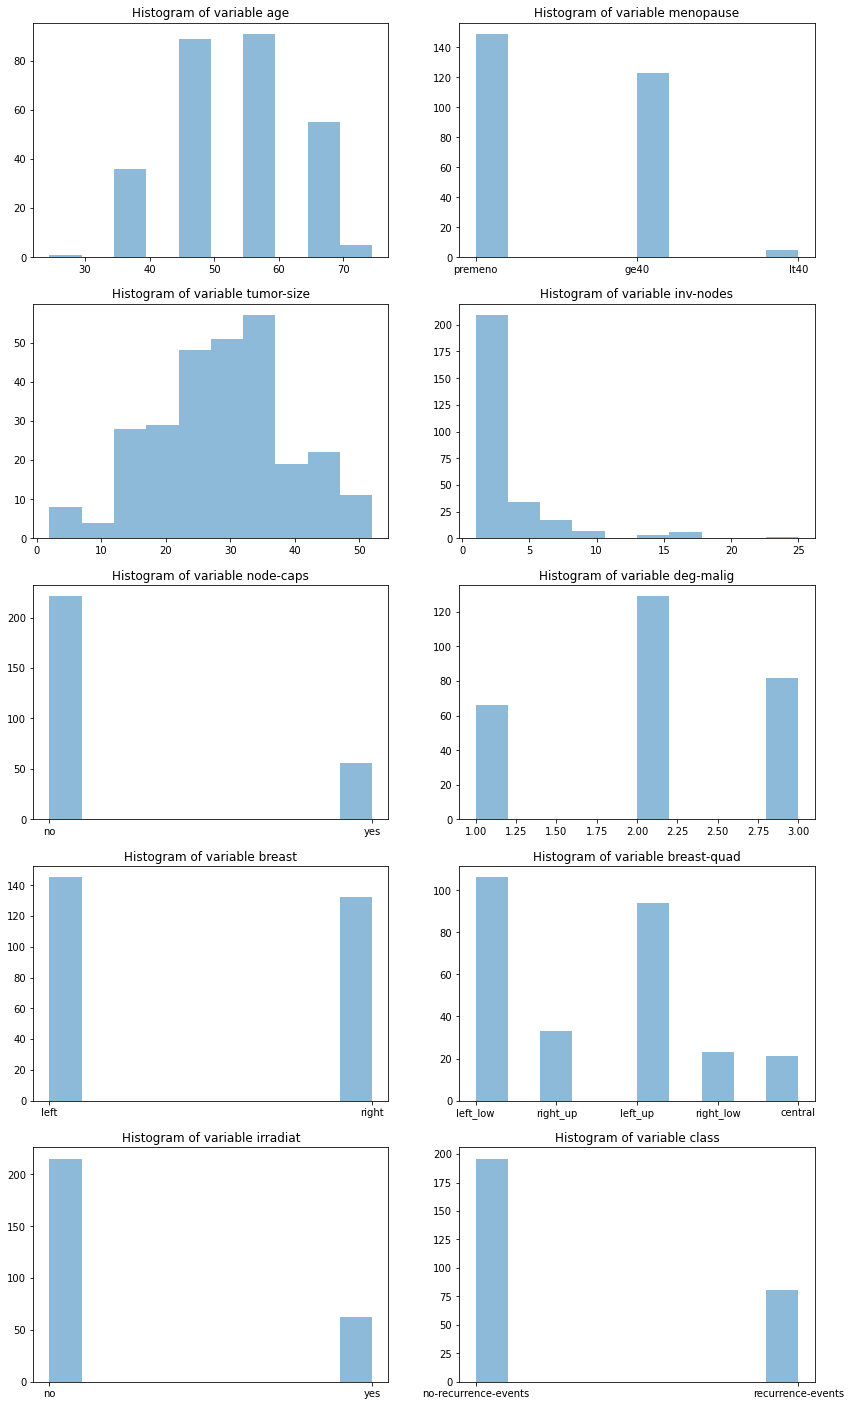

In [18]:
plt.rcParams["figure.figsize"] = (14,25)
for i in range(ncol):
    var = columns[i]
    place = ''.join(['52',str(i)])
    plt.subplot(place)
    plt.hist(df1[var], alpha=0.5)
    plt.title(''.join(['Histogram of variable ',var]))
plt.show()

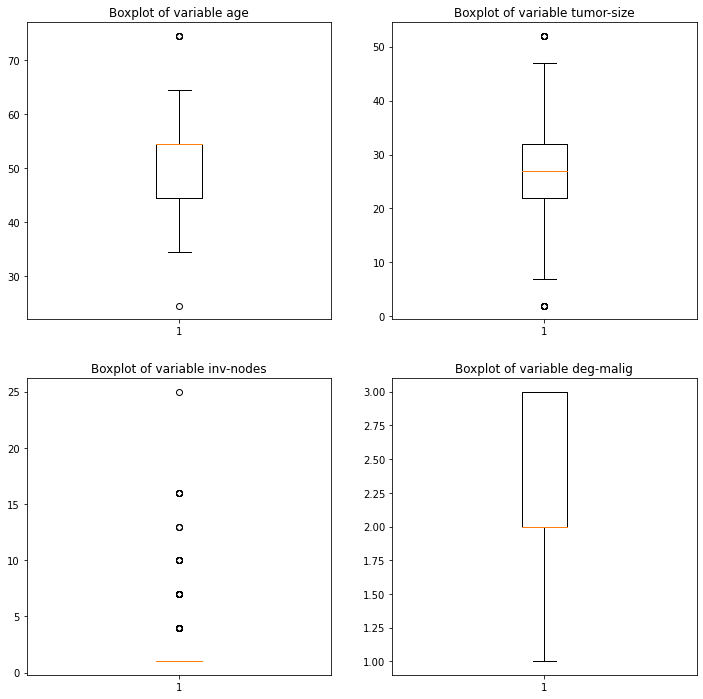

In [19]:
plt.rcParams["figure.figsize"] = (12,12)
for i in range(4):
    variables = ['age','tumor-size','inv-nodes','deg-malig']
    var = variables[i]
    place = ''.join(['22',str(i+1)])
    plt.subplot(place)
    plt.boxplot(df1[var])
    plt.title(''.join(['Boxplot of variable ',var]))
plt.show()

### dummy variable (one-hot encoding)

In [20]:
df_dummies = pd.get_dummies(df1['menopause'])
del df_dummies[df_dummies.columns[1]]

df_new = pd.concat([df1, df_dummies], axis=1)
del df_new['menopause']

In [21]:
df_dummies = pd.get_dummies(df1['node-caps'])
del df_dummies[df_dummies.columns[0]]
df_dummies.columns=['node-caps-yes']

df_new = pd.concat([df_new, df_dummies], axis=1)
del df_new['node-caps']

In [22]:
df_dummies = pd.get_dummies(df1['breast'])
del df_dummies[df_dummies.columns[1]]
df_dummies.columns=['breast-left']

df_new = pd.concat([df_new, df_dummies], axis=1)
del df_new['breast']

In [23]:
df_dummies = pd.get_dummies(df1['breast-quad'])
del df_dummies[df_dummies.columns[0]]

df_new = pd.concat([df_new, df_dummies], axis=1)
del df_new['breast-quad']

In [24]:
df_dummies = pd.get_dummies(df1['irradiat'])
del df_dummies[df_dummies.columns[1]]
df_dummies.columns=['irradiat-no']

df_new = pd.concat([df_new, df_dummies], axis=1)
del df_new['irradiat']

In [25]:
df_dummies = pd.get_dummies(df1['class'])
del df_dummies[df_dummies.columns[0]]

df_new = pd.concat([df_new, df_dummies], axis=1)
del df_new['class']

In [26]:
df_new

,age,tumor-size,inv-nodes,deg-malig,ge40,premeno,node-caps-yes,breast-left,left_low,left_up,right_low,right_up,irradiat-no,recurrence-events
0,34.5,32.0,1.0,3,0,1,0,1,1,0,0,0,1,0
1,44.5,22.0,1.0,2,0,1,0,0,0,0,0,1,1,0
2,44.5,22.0,1.0,2,0,1,0,1,1,0,0,0,1,0
3,64.5,17.0,1.0,2,1,0,0,0,0,1,0,0,1,0
4,44.5,2.0,1.0,2,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,34.5,32.0,1.0,2,0,1,0,1,0,1,0,0,1,1
273,34.5,22.0,1.0,3,0,1,0,1,0,1,0,0,0,1
274,64.5,22.0,1.0,1,1,0,0,0,0,1,0,0,1,1
275,44.5,32.0,4.0,3,1,0,0,1,1,0,0,0,1,1


### 상관관계 분석

In [27]:
df_new.corr()

,age,tumor-size,inv-nodes,deg-malig,ge40,premeno,node-caps-yes,breast-left,left_low,left_up,right_low,right_up,irradiat-no,recurrence-events
age,1.000000,-0.004700,-0.064067,-0.065260,0.705907,-0.716330,-0.044446,0.041744,-0.000851,0.057436,-0.074996,-0.024379,0.075946,-0.086981
tumor-size,-0.004700,1.000000,0.163618,0.209259,0.002230,0.012760,0.205537,-0.050005,0.009171,0.068768,-0.130673,0.161940,-0.168402,0.188848
inv-nodes,-0.064067,0.163618,1.000000,0.340156,0.014574,0.001473,0.616589,0.014246,0.018370,-0.014567,0.062885,0.004322,-0.296590,0.295989
deg-malig,-0.065260,0.209259,0.340156,1.000000,0.048813,-0.045776,0.330181,0.045874,-0.001251,0.058286,-0.041809,0.016729,-0.230821,0.330253
ge40,0.705907,0.002230,0.014574,0.048813,1.000000,-0.964229,-0.015675,0.052571,-0.015975,0.050025,-0.058273,-0.059514,0.061548,-0.047401
premeno,-0.716330,0.012760,0.001473,-0.045776,-0.964229,1.000000,0.033847,-0.057940,0.014629,-0.054492,0.068969,0.050273,-0.080780,0.070514
node-caps-yes,-0.044446,0.205537,0.616589,0.330181,-0.015675,0.033847,1.000000,0.012345,-0.007945,-0.019053,0.011408,0.064613,-0.333537,0.289002
breast-left,0.041744,-0.050005,0.014246,0.045874,0.052571,-0.057940,0.012345,1.000000,0.290184,-0.232128,0.103742,-0.184626,0.025230,0.041304
left_low,-0.000851,0.009171,0.018370,-0.001251,-0.015975,0.014629,-0.007945,0.290184,1.000000,-0.564278,-0.236920,-0.289546,-0.022710,0.032717
left_up,0.057436,0.068768,-0.014567,0.058286,0.050025,-0.054492,-0.019053,-0.232128,-0.564278,1.000000,-0.215668,-0.263573,-0.035859,-0.041693


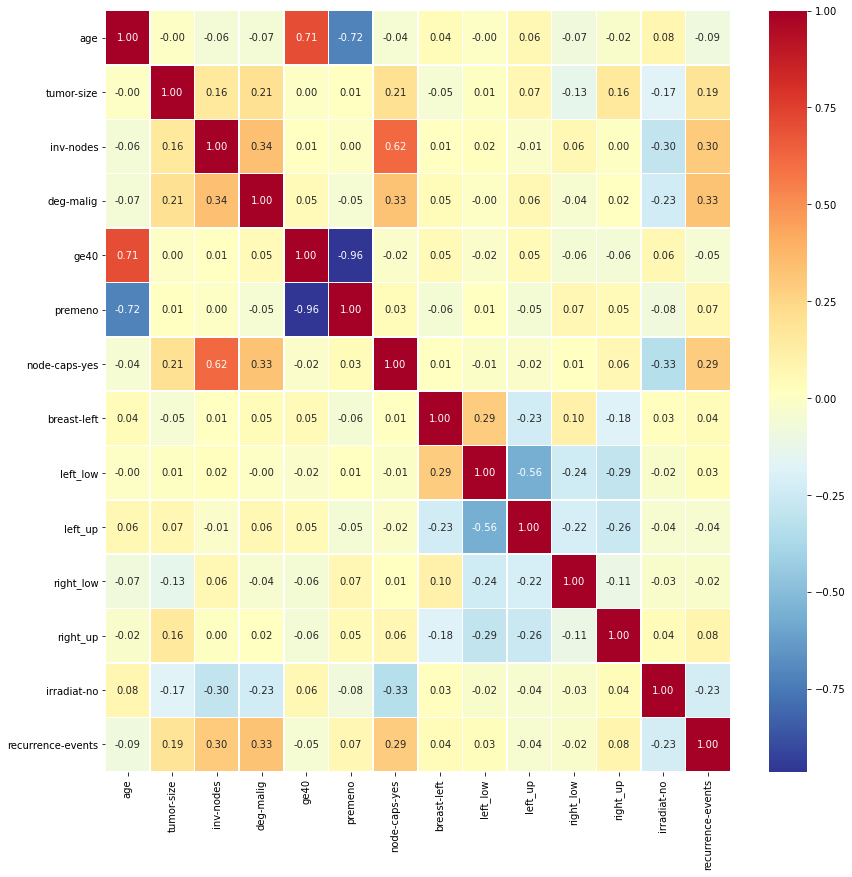

In [28]:
plt.figure(figsize=(14,14))
sns.heatmap(data=df_new.corr(method='pearson'), annot=True, fmt = '.2f', linewidths=.5, cmap='RdYlBu_r')

(age,ge40), (inv-nodes,node-caps-yes) 가 매우 강한 양의 상관관계를,  
(age,premeno), (ge40,premeno) 가 매우 강한 음의 상관관계를,   
(left_low,left_up) 가 강한 음의 상관관계를 가지는 것으로 보인다.

In [29]:
X = ['age','inv-nodes','age','ge40','left_low']
Y = ['ge40','node-caps-yes','premeno','premeno','left_up']

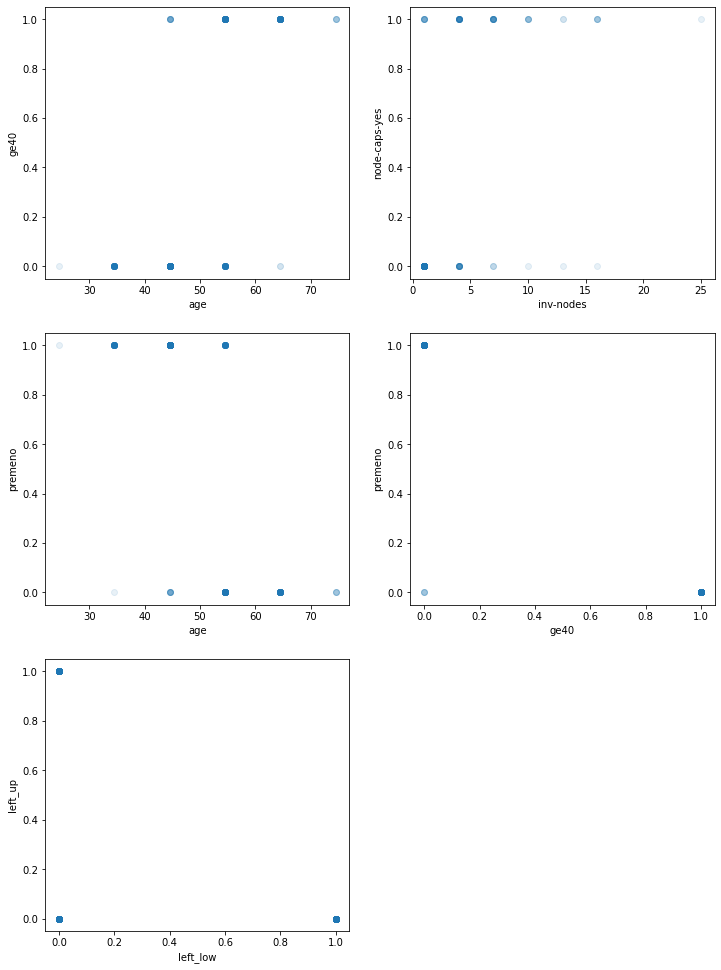

In [30]:
plt.rcParams["figure.figsize"] = (12,17)
for i in range(5):
    place = ''.join(['32',str(i+1)])
    plt.subplot(place)
    plt.scatter(df_new[X[i]],df_new[Y[i]], alpha=0.1)
    plt.xlabel(X[i])
    plt.ylabel(Y[i])
plt.show()

In [31]:
for i in range(5):
    print('{',X[i],'&',Y[i],'}')
    print('Covariance: {:.2f}'.format(np.cov(df_new[X[i]],df_new[Y[i]])[0,1]))
    print('Correlation: {:.2f}'.format(stats.pearsonr(df_new[X[i]],df_new[Y[i]])[0]))
    print('P-value: {:.4f}'.format(stats.pearsonr(df_new[X[i]],df_new[Y[i]])[1]))
    print('\n')

{ age & ge40 }
Covariance: 3.55
Correlation: 0.71
P-value: 0.0000


{ inv-nodes & node-caps-yes }
Covariance: 0.85
Correlation: 0.62
P-value: 0.0000


{ age & premeno }
Covariance: -3.61
Correlation: -0.72
P-value: 0.0000


{ ge40 & premeno }
Covariance: -0.24
Correlation: -0.96
P-value: 0.0000


{ left_low & left_up }
Covariance: -0.13
Correlation: -0.56
P-value: 0.0000




귀무가설 '상관관계가 없다' 기각   

Pearson chi-square test

In [32]:
# contingency table
cont1 = pd.crosstab(df_new[X[0]],df_new[Y[0]], margins=True)
cont2 = pd.crosstab(df_new[X[1]],df_new[Y[1]], margins=True)
cont3 = pd.crosstab(df_new[X[2]],df_new[Y[2]], margins=True)
cont4 = pd.crosstab(df_new[X[3]],df_new[Y[3]], margins=True)
cont5 = pd.crosstab(df_new[X[4]],df_new[Y[4]], margins=True)

In [33]:
# Expected
def exact(i):
    cont = pd.crosstab(df_new[X[i]],df_new[Y[i]], margins=True)
    without = pd.crosstab(df_new[X[i]],df_new[Y[i]])
    nrow = cont.shape[0]-1
    ncol = cont.shape[1]-1
    exp = np.zeros((nrow,ncol))
    for j in range(nrow):
        for k in range(ncol):
            exp[j,k] = cont.iloc[j,ncol]*cont.iloc[nrow,k]/cont.iloc[nrow,ncol]
    lessthan5 = (exp<5).sum()/(nrow*ncol)
    if lessthan5 > 0.2 :
        print('Do Fisher Exact test')
    else :
        print('Do chi-square test')

In [34]:
for i in range(5):
    print('For pair number', i+1)
    exact(i)

For pair number 1
Do Fisher Exact test
For pair number 2
Do Fisher Exact test
For pair number 3
Do Fisher Exact test
For pair number 4
Do chi-square test
For pair number 5
Do chi-square test


범주가 2개 이상이라서 Fisher's exact test 불가  
모든 pair에 대해 chi-square test 진행

In [35]:
# chi square
def chi(var1,var2):
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_new[var1],df_new[var2]))
    alpha = 0.05
    print('P-value is {:.4f}'.format(p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')

In [36]:
for i in range(5):
    print('{',X[i],'&',Y[i],'}')
    chi(X[i],Y[i])
    print('\n')

{ age & ge40 }
P-value is 0.0000
Dependent (reject H0)


{ inv-nodes & node-caps-yes }
P-value is 0.0000
Dependent (reject H0)


{ age & premeno }
P-value is 0.0000
Dependent (reject H0)


{ ge40 & premeno }
P-value is 0.0000
Dependent (reject H0)


{ left_low & left_up }
P-value is 0.0000
Dependent (reject H0)




In [37]:
# Fisher's exact test - 범주가 2개 이상이라서 계산 불가(rpy2 패키지 설치시 가능)
def fisher(var1,var2):
    oddsratio, pvalue = stats.fisher_exact(pd.crosstab(df_new[var1],df_new[var2]))
    alpha = 0.05
    print('P-value is {:.4f}'.format(p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')

모든 pair가 연관되어 있다.

### 종속변수에 따른 변수들의 분포

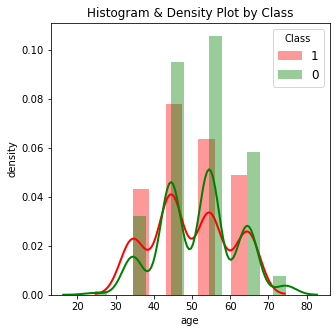

In [38]:
plt.rcParams["figure.figsize"] = (5,5)
grp_col_dict = {1:'red',0:'green'}

for group in grp_col_dict:
    subset = df_new[df_new['recurrence-events'] == group]
    sns.distplot(subset['age'], hist = True, kde = True, kde_kws = {'linewidth': 2}, color = grp_col_dict[group], label = group)

plt.title('Histogram & Density Plot by Class')
plt.xlabel('age')
plt.ylabel('density')
plt.legend(prop={'size': 12}, title = 'Class')
plt.show()

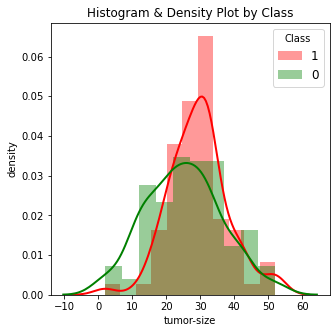

In [39]:
plt.rcParams["figure.figsize"] = (5,5)
grp_col_dict = {1:'red',0:'green'}

for group in grp_col_dict:
    subset = df_new[df_new['recurrence-events'] == group]
    sns.distplot(subset['tumor-size'], hist = True, kde = True, kde_kws = {'linewidth': 2}, color = grp_col_dict[group], label = group)

plt.title('Histogram & Density Plot by Class')
plt.xlabel('tumor-size')
plt.ylabel('density')
plt.legend(prop={'size': 12}, title = 'Class')
plt.show()

<ipython-input-40-6d6cfe7f4a95>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(7,2,i+1)


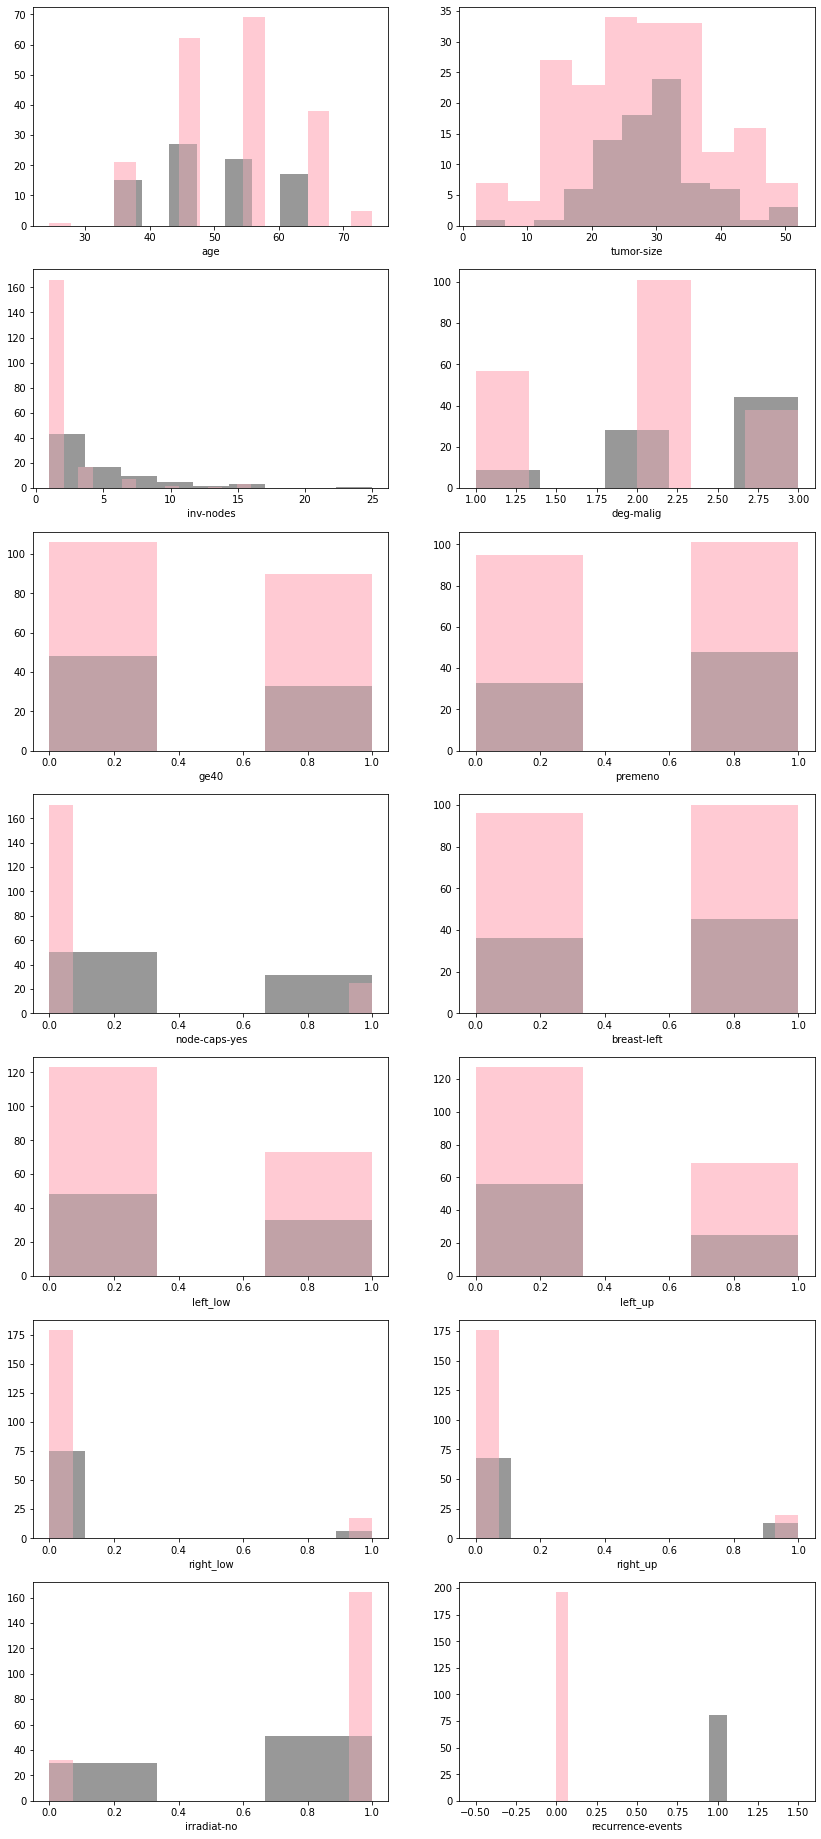

In [40]:
fig = plt.figure(figsize=(14,33))
grp_col_dict = {1:'gray',0:'pink'}
columns = df_new.columns
ncol = df_new.shape[1]

for i in range(ncol):
    var = columns[i]
    for group in grp_col_dict:
        subset = df_new[df_new['recurrence-events'] == group]
        for i in range(ncol):
            plt.subplot(7,2,i+1)
            sns.distplot(subset[columns[i]], kde=False, color = grp_col_dict[group], label = group, hist_kws=dict(alpha=0.1))
plt.show()

<ipython-input-41-f860202c2f6a>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(7,2,i+1)


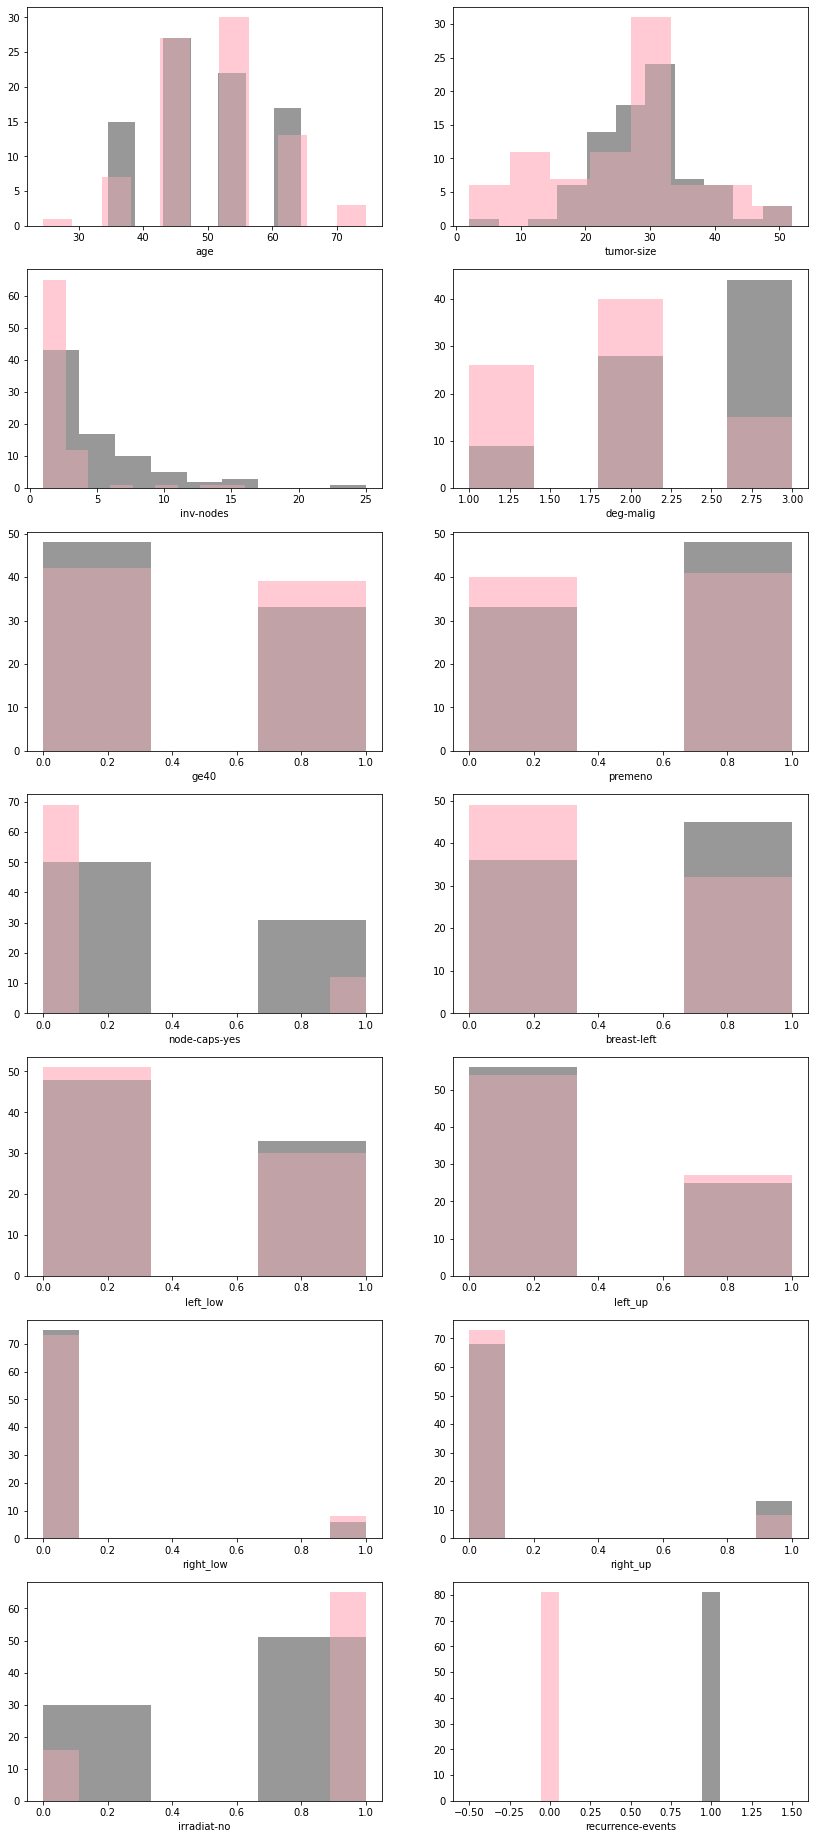

In [41]:
# class 비율 같게 해서 확인
fig = plt.figure(figsize=(14,33))
grp_col_dict = {1:'gray',0:'pink'}
smaller = df_new[df_new['recurrence-events'] == 1].shape[0]

for i in range(ncol):
    for group in grp_col_dict:
        subset = df_new[df_new['recurrence-events'] == group]
        nrow = subset.shape[0]
        if group==0:
            subset = subset.sample(n=smaller,random_state=0)
        for i in range(ncol):
            plt.subplot(7,2,i+1)
            sns.distplot(subset[columns[i]], kde=False, color = grp_col_dict[group], label = group, hist_kws=dict(alpha=0.1))
plt.show()